# Connect to Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import os
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import gc
import time
import traceback
from transformers import BertModel, BertTokenizer, AdamW, get_cosine_schedule_with_warmup
from tqdm import tqdm
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix, f1_score


# For reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

# Forcing pytorch to use GPU instead of the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Dataset Loading

Here, we load the dataset files from our google drive folder. Similarly, we have a relation_types.json file, which includes all the relationship types within the dataset (this file was generated in a different python file earlier).

Additionally, we highlight some basic statistics to better understand the data.

In [3]:
# Helper function to load the dataset
def load_dataset(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# GDrive path to dataset
data_dir = '/content/drive/My Drive/retacred_dataset_nonprocessed'

# Loading the train, dev and test datasets
train_data = load_dataset(os.path.join(data_dir, 'train.json'))
dev_data = load_dataset(os.path.join(data_dir, 'dev.json'))
test_data = load_dataset(os.path.join(data_dir, 'test.json'))

# Loading the relation types
relation_types_path = os.path.join(data_dir, 'relation_types.json')
with open(relation_types_path, 'r', encoding='utf-8') as f:
  relation_types = json.load(f)

print(f"Number of relation types: {len(relation_types)}")

# Some basic numbers
print(f"\nDataset Statistics:")
print(f"Train samples: {len(train_data)}")
print(f"Dev samples: {len(dev_data)}")
print(f"Test samples: {len(test_data)}")

# Checking relation distribution in train set
relation_counts = Counter([sample['relation'] for sample in train_data])
print(f"\nTop 5 relations in training set:")
for relation, count in relation_counts.most_common(5):
  print(f"  - {relation}: {count} samples ({count/len(train_data)*100:.2f}%)")

# Checkin entity types
subj_types = Counter([sample['subj_type'] for sample in train_data])
obj_types = Counter([sample['obj_type'] for sample in train_data])

print(f"\nSubject entity types: {', '.join(subj_types.keys())}")
print(f"Object entity types: {', '.join(obj_types.keys())}")

Number of relation types: 40

Dataset Statistics:
Train samples: 58465
Dev samples: 19584
Test samples: 13418

Top 5 relations in training set:
  - no_relation: 38761 samples (66.30%)
  - per:identity: 5320 samples (9.10%)
  - per:title: 2626 samples (4.49%)
  - per:employee_of: 2136 samples (3.65%)
  - org:top_members/employees: 1475 samples (2.52%)

Subject entity types: ORGANIZATION, PERSON
Object entity types: PERSON, ORGANIZATION, NUMBER, DATE, NATIONALITY, TITLE, COUNTRY, CRIMINAL_CHARGE, CITY, RELIGION, LOCATION, DURATION, URL, STATE_OR_PROVINCE, IDEOLOGY, CAUSE_OF_DEATH


# Preprocessing Dataset

In this cell, we primarily create label mappings and basically prepare the data for use in BERT.

This includes label mappings from the relation names to their ID's, bert tokenizer initialization, dynamically generating entity markers based on the entity types found, etc.

In [4]:
# Creating label mappings to map the relations to their ID's
label2id = {label: i for i, label in enumerate(relation_types)}
id2label = {i: label for i, label in enumerate(relation_types)}

print(f"Number of relation classes: {len(label2id)}")

# Initializing a BERT tokenizer (only the base case one due to size)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Getting entity types
all_subj_types = set(sample['subj_type'] for sample in train_data)
all_obj_types = set(sample['obj_type'] for sample in train_data)
all_entity_types = all_subj_types.union(all_obj_types)

# Generating entity markers
entity_markers = []
for t in sorted(all_subj_types.union(all_obj_types)):
    entity_markers += [f'[S:{t}]', f'[/S:{t}]', f'[O:{t}]', f'[/O:{t}]']
tokenizer.add_special_tokens({'additional_special_tokens': entity_markers})



Number of relation classes: 40


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

64

# Model Operations
## BERT Dataset Class

Within this, we define the primary dataset class for Re-TACRED's use in BERT.

In [5]:
# Define the dataset class
class RelationExtractionDataset(Dataset):
    # Dataset class for relation extraction which inserts entity markers around subject and object entities in the input text.

    def __init__(self, data, tokenizer, max_length=256, label2id=None):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label2id = label2id

         # Counters to keep track of truncated samples and statistics (we disable the truncated filter later on tho)
        self.truncated_count = 0
        self.stats = {"entity_truncated": 0, "total": len(data)}
        self._calculate_sequence_stats()

    # Precalculating length stats for a sample of the data
    def _calculate_sequence_stats(self):
        # Pre-calculate sequence length statistics for reporting
        sample_size = min(1000, len(self.data))
        lengths = []
        for item in random.sample(self.data, sample_size):
            # Estimating the length
            length = len(item['token']) + 4
            lengths.append(length)

        # 95 percentile
        p95 = int(np.percentile(lengths, 95))
        self.avg_len = sum(lengths) / len(lengths)
        self.max_len = max(lengths)
        self.p95_len = p95

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Get the sample
        item = self.data[idx]
        tokens = item['token'].copy()

        # getting the entity positions and types
        subj_start = item['subj_start']
        subj_end = item['subj_end']  # Last token of subject
        obj_start = item['obj_start']
        obj_end = item['obj_end']    # Last token of object
        subj_type = item['subj_type']
        obj_type = item['obj_type']

        # Inserting entity markers at the correct positions.
        # The insertion order will depend on whether the subject comes before the object
        if subj_end < obj_start:
            # If the subject comes before object
            tokens.insert(subj_start, f'[S:{subj_type}]')
            tokens.insert(subj_end + 2, f'[/S:{subj_type}]')  # Adjust index because of insertion
            # Update object positions
            obj_start += 2
            tokens.insert(obj_start, f'[O:{obj_type}]')
            tokens.insert(obj_end + 2, f'[/O:{obj_type}]')
        else:
            # If obj comes before subject
            tokens.insert(obj_start, f'[O:{obj_type}]')
            tokens.insert(obj_end + 2, f'[/O:{obj_type}]')  # +2 because we of insertion and adjustment
            # Update subject positions
            subj_start += 2
            subj_end += 2
            tokens.insert(subj_start, f'[S:{subj_type}]')
            tokens.insert(subj_end + 2, f'[/S:{subj_type}]')

        # Converting token list back into a single string
        text = " ".join(tokens)

        # Tokenizing the text within maximum length
        encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        # Entity marker truncation check
        entity_truncated = False

        # Convert to string for easier checking of entity markers beinmg lost
        decoded_text = self.tokenizer.decode(input_ids)
        if (f'[S:{subj_type}]' not in decoded_text or
            f'[/S:{subj_type}]' not in decoded_text or
            f'[O:{obj_type}]' not in decoded_text or
            f'[/O:{obj_type}]' not in decoded_text):
            entity_truncated = True
            self.truncated_count += 1

        # Mapping the sample data's relation to its label ID
        if self.label2id is not None:
            label_id = torch.tensor(self.label2id[item['relation']])
        else:
            label_id = torch.tensor(-1)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label_id,
            'instance_id': item.get('id', 'unknown'),
            'entity_truncated': entity_truncated
        }

# Helper function to calculate optimal maximum length
def find_optimal_max_length(tokenizer, data_sample, percentile=95):
    # Analyze a subset of the data to calculate a good max_length parameter
    if len(data_sample) > 1000:
        data_sample = random.sample(data_sample, 1000)

    lengths = []
    for item in tqdm(data_sample, desc="Analyzing sequence lengths"):
        # Get the token list
        tokens = item['token'].copy()

        # Add 4 placeholder tokens for entity markers and calc token length with the bert tokenizer (with special tokens)
        tokens.extend(['[MARKER1]', '[MARKER2]', '[MARKER3]', '[MARKER4]'])
        encoding = tokenizer(" ".join(tokens), add_special_tokens=True)
        lengths.append(len(encoding['input_ids']))

    # Calculate percentile length and rounding it
    optimal_length = int(np.percentile(lengths, percentile))
    optimal_length = ((optimal_length + 31) // 32) * 32

    # sum stats
    avg_len = sum(lengths) / len(lengths)
    max_len = max(lengths)

    print(f"Sequence length statistics:")
    print(f"  - Average length: {avg_len:.1f} tokens")
    print(f"  - Maximum length: {max_len} tokens")
    print(f"  - {percentile}th percentile: {optimal_length} tokens")

    # BERT's maximum is 512 (shouldnt exceed it)
    return min(optimal_length, 512)

# Optimal max length for re-tacred
MAX_LENGTH = find_optimal_max_length(tokenizer, train_data, percentile=98)
print(f"Using MAX_LENGTH = {MAX_LENGTH} tokens for model input")

# Batch size depends on sequence length
if MAX_LENGTH <= 128:
    BATCH_SIZE = 32
elif MAX_LENGTH <= 256:
    BATCH_SIZE = 16
else:
    BATCH_SIZE = 8

print(f"Using batch size = {BATCH_SIZE} based on sequence length")

Analyzing sequence lengths: 100%|██████████| 1000/1000 [00:00<00:00, 1235.27it/s]


Sequence length statistics:
  - Average length: 77.9 tokens
  - Maximum length: 233 tokens
  - 98th percentile: 160 tokens
Using MAX_LENGTH = 160 tokens for model input
Using batch size = 16 based on sequence length


## Creating Dataset Based on Mappings

Here, we create the dataset based on mappings performed in the previous code block.

In [6]:
# Creating datasets with entity markers from before
train_dataset = RelationExtractionDataset(train_data, tokenizer, max_length=MAX_LENGTH, label2id=label2id)
dev_dataset = RelationExtractionDataset(dev_data, tokenizer, max_length=MAX_LENGTH, label2id=label2id)
test_dataset = RelationExtractionDataset(test_data, tokenizer, max_length=MAX_LENGTH, label2id=label2id)

# Filter out instances where entities are truncated (this is turned off for now, not needed)
FILTER_TRUNCATED = False
def filter_dataset(dataset):
    """Filter out instances where entity markers were truncated"""
    indices = []
    for i in range(len(dataset)):
        item = dataset[i]
        if not item['entity_truncated']:
            indices.append(i)

    filtered = torch.utils.data.Subset(dataset, indices)
    print(f"Filtered {len(dataset) - len(indices)} instances with truncated entities")
    print(f"Remaining: {len(indices)} instances ({len(indices)/len(dataset)*100:.1f}%)")
    return filtered

# Apply filtering if enabled
# if FILTER_TRUNCATED:
#     print("\nFiltering instances with truncated entities...")
#     train_dataset = filter_dataset(train_dataset)
#     dev_dataset = filter_dataset(dev_dataset)
#     test_dataset = filter_dataset(test_dataset)

# Using Dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Data loaders created:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Dev   batches: {len(dev_dataloader)}")
print(f"Test  batches: {len(test_dataloader)}")

Data loaders created:
Train batches: 3655
Dev   batches: 1224
Test  batches: 839


## Model Definition

In [7]:
class BERTForRelationExtraction(nn.Module):
    # Entity-aware model that uses BERT, plus an attention mechanism over the sequencewith the [CLS] as query, using a multi-classification head.
    # All BERT layers are unfrozen
    def __init__(self, num_labels):
        super(BERTForRelationExtraction, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')

        # Updating token embeddings for new markers
        self.bert.resize_token_embeddings(len(tokenizer))

        self.hidden_size = self.bert.config.hidden_size

        for param in self.bert.parameters():
            param.requires_grad = True

        # Entity-aware attention thing with multi head attention
        self.entity_attention = nn.MultiheadAttention(
            embed_dim=self.hidden_size,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.1)

        # The multi layer classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_size, self.hidden_size // 2),
            nn.LayerNorm(self.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.hidden_size // 2, num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        # Obtain BERT outputs
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            return_dict=True)

        sequence_output = outputs.last_hidden_state
        # Get [CLS] token embedding
        cls_output = sequence_output[:, 0, :]

        # Applying ntity-aware attention using CLS as query
        cls_expanded = cls_output.unsqueeze(1)
        attended_output, _ = self.entity_attention(
            cls_expanded,
            sequence_output,
            sequence_output,
            key_padding_mask=(attention_mask == 0)
        )
        attended_output = attended_output.squeeze(1)

        # Combine [CLS] and attention result
        combined = torch.cat([cls_output, attended_output], dim=1)
        combined = self.dropout(combined)
        # Classifying it
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

## Model Training Parameters

In [8]:
# Function to train one epoch with optional mixup. Supports gradient accumulation aswell.
def train_epoch(model, dataloader, optimizer, scheduler, device,
                use_mixup=True, mixup_alpha=0.2, gradient_accumulation_steps=1):

    model.train()
    total_loss = 0
    total_steps = 0
    skipped_batches = 0
    progress_bar = tqdm(dataloader, desc="Training")
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(progress_bar):
        # Get batch data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Skip batches where entities were truncated (wasnt done here so not required)
        if 'entity_truncated' in batch:
            entity_truncated = batch.get('entity_truncated', torch.zeros(len(input_ids), dtype=torch.bool))
            if isinstance(entity_truncated, torch.Tensor) and entity_truncated.all():
                skipped_batches += 1
                continue

        # Using mixup augmentation on alternating batches
        if use_mixup and (batch_idx % 2 == 0):
            lam = np.random.beta(mixup_alpha, mixup_alpha)
            index = torch.randperm(input_ids.size(0)).to(device)

            with torch.set_grad_enabled(True):
                # OG samples
                outputs1 = model(input_ids, attention_mask)
                logits1 = outputs1['logits']
                # Permuted samples
                outputs2 = model(input_ids[index], attention_mask[index])
                logits2 = outputs2['logits']
                # Mix logits
                mixed_logits = lam * logits1 + (1 - lam) * logits2
                loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
                loss_a = loss_fn(mixed_logits, labels)
                loss_b = loss_fn(mixed_logits, labels[index])
                loss = lam * loss_a + (1 - lam) * loss_b
        else:
            # Normal forward pass w/o the mixup
            outputs = model(input_ids, attention_mask, labels=labels)
            loss = outputs['loss']

        # Applying gradient accumulation
        loss = loss / gradient_accumulation_steps
        loss.backward()

        total_loss += loss.item() * gradient_accumulation_steps
        total_steps += 1

        if ((batch_idx + 1) % gradient_accumulation_steps == 0) or (batch_idx + 1 == len(dataloader)):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        progress_bar.set_postfix({
            'loss': loss.item() * gradient_accumulation_steps,
            'lr': scheduler.get_last_lr()[0]
        })

        # Memory cleanup cuz of GPU limits
        if batch_idx > 0 and batch_idx % 100 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    avg_loss = total_loss / max(1, total_steps)
    return avg_loss

# Function to evaluate the model on the provided dataloader. Returns metrics including loss and F1 scores.
def evaluate(model, dataloader, device, return_predictions=False):

    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_logits = []
    valid_batches = 0
    skipped_batches = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Skip batches where entities were truncated (not rlly done here)
            if 'entity_truncated' in batch:
                entity_truncated = batch.get('entity_truncated', torch.zeros(len(input_ids), dtype=torch.bool))
                if isinstance(entity_truncated, torch.Tensor) and entity_truncated.all():
                    skipped_batches += 1
                    continue

            outputs = model(input_ids, attention_mask, labels=labels)
            loss = outputs['loss']
            logits = outputs['logits']

            total_loss += loss.item()
            valid_batches += 1

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            if return_predictions:
                all_logits.append(logits.cpu().numpy())

    # If no valid batches, return dummy metrics
    if valid_batches == 0:
        return {
            'loss': float('inf'),
            'micro_f1': 0.0,
            'macro_f1': 0.0,
            'filtered_f1': 0.0
        }

    avg_loss = total_loss / valid_batches

    if return_predictions and all_logits:
        all_logits = np.vstack(all_logits)

    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Handling 'no_relation' filtering if it exists i.e., excluding the no relation class if needed
    no_relation_idx = label2id.get('no_relation', None)
    filtered_f1 = 0.0
    if no_relation_idx is not None:
        y_true_arr = np.array(all_labels)
        y_pred_arr = np.array(all_preds)
        mask = (y_true_arr != no_relation_idx) | (y_pred_arr != no_relation_idx)
        if mask.sum() > 0:
            filtered_f1 = f1_score(y_true_arr[mask], y_pred_arr[mask], average='micro')
    else:
        filtered_f1 = micro_f1

    metrics = {
        'loss': avg_loss,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'filtered_f1': filtered_f1
    }

    if return_predictions:
        metrics['predictions'] = all_preds
        metrics['labels'] = all_labels
        if all_logits is not None and len(all_logits) > 0:
            metrics['logits'] = all_logits

    return metrics

# Function to Calculate class weights to handle class imbalance.
def calculate_class_weights(labels, num_classes):
    counts = np.bincount(labels, minlength=num_classes)
    counts = np.where(counts > 0, counts, 1)
    weights = 1.0 / counts
    weights = weights * (num_classes / weights.sum())
    return torch.FloatTensor(weights)

## Model Initialization

In [9]:


num_labels = len(label2id)
print(f"Initializing model with {num_labels} output classes")

# Initialize the BERT model
model = BERTForRelationExtraction(num_labels=num_labels)

# Resizing token embeddings to account for special entity markers
model.bert.resize_token_embeddings(len(tokenizer))

# Move model to GPU if not already
model.to(device)
print(f"Model initialized and moved to {device}")

# Calculating class weights to handle imbalance (especially the 'no_relation' class)
train_labels = [label2id[sample['relation']] for sample in train_data]
class_weights = calculate_class_weights(train_labels, num_labels)
class_weights = class_weights.to(device)

print("Class weights calculated to handle imbalance")

# Printing top 5 and bottom 5 class weights
sorted_weights = sorted(
    zip(range(num_labels), class_weights.tolist()),
    key=lambda x: x[1],
    reverse=True
)
print("\nTop 5 class weights (underrepresented classes):")
for idx, weight in sorted_weights[:5]:
    print(f"  - {id2label[idx]}: {weight:.4f}")

print("\nBottom 5 class weights (overrepresented classes):")
for idx, weight in sorted_weights[-5:]:
    print(f"  - {id2label[idx]}: {weight:.4f}")

# Optimizer groups with the weight decay config
# No weight decay for biases and layernorm params
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {
        # Weight decay for all parameters not in the no_decay list
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01
    },
    {
        # No weight decay for biases and LayerNorm weights
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    },
]

# Training hyperparameters
EPOCHS = 12
WARMUP_RATIO = 0.1
LR = 2e-5
GRADIENT_ACCUMULATION_STEPS = 1

# Adjusting the learning rate based on batch size and gradient accumulation (follows linear scaling in relation tot the batch size)
effective_batch_size = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
base_lr = 2e-5
LR = base_lr * (effective_batch_size / 16)

# Calculate total training steps and warmup steps
total_steps = len(train_dataloader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

# Initializing the optimizer and learning rate scheduler
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# printin
print(f"\nTraining Configuration:")
print(f"  - Learning Rate: {LR}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Gradient Accumulation Steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  - Effective Batch Size: {effective_batch_size}")
print(f"  - Total Training Steps: {total_steps}")
print(f"  - Warmup Steps: {warmup_steps} ({WARMUP_RATIO*100:.0f}%)")
print("Completed")


Initializing model with 40 output classes


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model initialized and moved to cuda
Class weights calculated to handle imbalance

Top 5 class weights (underrepresented classes):
  - per:country_of_death: 13.4510
  - org:dissolved: 3.5090
  - per:country_of_birth: 3.2282
  - per:stateorprovince_of_birth: 1.8342
  - org:number_of_employees/members: 1.4946

Bottom 5 class weights (overrepresented classes):
  - org:top_members/employees: 0.0547
  - per:employee_of: 0.0378
  - per:title: 0.0307
  - per:identity: 0.0152
  - no_relation: 0.0021

Training Configuration:
  - Learning Rate: 2e-05
  - Batch Size: 16
  - Gradient Accumulation Steps: 1
  - Effective Batch Size: 16
  - Total Training Steps: 43860
  - Warmup Steps: 4386 (10%)
Completed


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Model Training Loop

We include early stopping and checkpoint saving in the below model training loop. The model uses the parameters stated in the earlier cells.

In [10]:
# Creating a checkpoint
checkpoint_dir = "bert_checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Created checkpoint directory: {checkpoint_dir}")

# Function to save checkpoints
def save_checkpoint(model, optimizer, scheduler, epoch, metrics, filename):
    # Save training checkpoint for resuming later (moving model state to CPU and saving it)
    with torch.cuda.device(device if torch.cuda.is_available() else 'cpu'):
        model_state = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'metrics': metrics,
        }, filename)

        # Cleaning the memory
        del model_state
        torch.cuda.empty_cache()
    print(f"Checkpoint saved to {filename}")
    return True

# Function for loading the checkpoint
def load_checkpoint(model, optimizer, scheduler, filename):
    # Load training checkpoint to resume training
    if os.path.isfile(filename):
        checkpoint = torch.load(filename, map_location=device)
        start_epoch = checkpoint['epoch'] + 1

        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])

        # Load optimizer state
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Load scheduler state if it's there
        if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Get metrics from checkpoint
        metrics = checkpoint.get('metrics', {})
        best_filtered_f1 = metrics.get('best_filtered_f1', 0.0)

        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        return start_epoch, best_filtered_f1
    else:
        print(f"No checkpoint found at {filename}")
        return 1, 0.0

# Function to update the learning rate manually for param groups
def update_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    return new_lr

# Check for existing checkpoint
latest_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pt")
start_epoch, best_filtered_f1 = load_checkpoint(model, optimizer, scheduler, latest_checkpoint) if os.path.exists(latest_checkpoint) else (1, 0.0)

# Some more parameters
best_model_state = None
patience = 3  # Early stopping patience
no_improvement_count = 0  # Counter for early stopping
training_start_time = time.time()  # Track total training time
train_losses = [] # List to store training loss for each epoch
val_losses = [] # List to store validation loss for each epoch

print("\n" + "_"*50)
print("STARTING TRAINING")
print("_"*50)

# Training loop
for epoch in range(start_epoch, EPOCHS + 1):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # Train for one epoch
    train_loss = train_epoch(
        model=model,
        dataloader=train_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        use_mixup=True,
        mixup_alpha=0.2,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
    )

    # Calculate epoch time in mins
    epoch_time = (time.time() - epoch_start_time) / 60
    print(f"Epoch complete in {epoch_time:.2f} minutes")
    print(f"Training loss: {train_loss:.4f}")


    # Save checkpoint after each epoch (lost my stuff the last time, dont modify this)
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epoch,
        metrics={'train_loss': train_loss, 'best_filtered_f1': best_filtered_f1},
        filename=os.path.join(checkpoint_dir, "latest_checkpoint.pt")
    )

    # Evaluating on dev set
    print("\nEvaluating on dev set...")
    dev_metrics = evaluate(model, dev_dataloader, device)
    dev_loss = dev_metrics['loss']
    dev_micro_f1 = dev_metrics['micro_f1']
    dev_macro_f1 = dev_metrics['macro_f1']
    dev_filtered_f1 = dev_metrics['filtered_f1']

    print(f"Dev loss: {dev_loss:.4f}")
    print(f"Dev Micro F1: {dev_micro_f1:.4f}, Dev Macro F1: {dev_macro_f1:.4f}")
    print(f"Dev F1 (filtered): {dev_filtered_f1:.4f}")

    # Recording losses for plottin
    train_losses.append(train_loss)
    val_losses.append(dev_loss)

    # Check if improved through filtered F1  (save if improved)
    improved = False
    if dev_filtered_f1 > best_filtered_f1:
        improvement = dev_filtered_f1 - best_filtered_f1
        best_filtered_f1 = dev_filtered_f1

        # Save best model state
        with torch.cuda.device(device if torch.cuda.is_available() else 'cpu'):
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            torch.cuda.empty_cache()

        print(f"New best model with F1 = {dev_filtered_f1:.4f} (improved by {improvement:.4f})")

        # Save best model checkpoint
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
            metrics={'train_loss': train_loss, 'dev_metrics': dev_metrics, 'best_filtered_f1': best_filtered_f1},
            filename=os.path.join(checkpoint_dir, "best_model.pt")
        )

        improved = True

        # Reset counter when improvement is noticed
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        print(f"No improvement in filtered F1. Current best: {best_filtered_f1:.4f}")
        print(f"Patience: {no_improvement_count}/{patience}")

        # Reduce the learning rate if no improvement for 2 epochs
        if no_improvement_count == 2:
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = current_lr * 0.5  # Reduce it by half
            update_learning_rate(optimizer, new_lr)
            print(f"Reducing learning rate from {current_lr} to {new_lr}")

    # Early stopping check if no improvement for the patience epochs
    if no_improvement_count >= patience:
        print(f"Early stopping triggered after {epoch} epochs")
        break

    # Estimated progress
    remaining_epochs = EPOCHS - epoch
    if remaining_epochs > 0:
        print(f"\nProgress: {epoch}/{EPOCHS} epochs completed ({epoch/EPOCHS*100:.1f}%)")
        print(f"Estimated remaining time: {remaining_epochs * epoch_time:.1f} minutes")

# Total training time in mins
total_time = (time.time() - training_start_time) / 60
print(f"\nTraining complete in {total_time:.2f} minutes")



Created checkpoint directory: bert_checkpoints

__________________________________________________
STARTING TRAINING
__________________________________________________

Epoch 1/12


Training: 100%|██████████| 3655/3655 [11:00<00:00,  5.53it/s, loss=0.707, lr=1.67e-5]


Epoch complete in 11.01 minutes
Training loss: 1.5992
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.33it/s]


Dev loss: 1.1514
Dev Micro F1: 0.8467, Dev Macro F1: 0.4546
Dev F1 (filtered): 0.6745
New best model with F1 = 0.6745 (improved by 0.6745)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 1/12 epochs completed (8.3%)
Estimated remaining time: 121.1 minutes

Epoch 2/12


Training: 100%|██████████| 3655/3655 [10:59<00:00,  5.54it/s, loss=0.703, lr=1.97e-5]


Epoch complete in 10.99 minutes
Training loss: 1.0098
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.40it/s]


Dev loss: 1.0409
Dev Micro F1: 0.8841, Dev Macro F1: 0.6492
Dev F1 (filtered): 0.7414
New best model with F1 = 0.7414 (improved by 0.0669)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 2/12 epochs completed (16.7%)
Estimated remaining time: 109.9 minutes

Epoch 3/12


Training: 100%|██████████| 3655/3655 [11:00<00:00,  5.54it/s, loss=0.683, lr=1.87e-5]


Epoch complete in 11.00 minutes
Training loss: 0.9098
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.37it/s]


Dev loss: 1.0024
Dev Micro F1: 0.8915, Dev Macro F1: 0.7152
Dev F1 (filtered): 0.7681
New best model with F1 = 0.7681 (improved by 0.0267)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 3/12 epochs completed (25.0%)
Estimated remaining time: 99.0 minutes

Epoch 4/12


Training: 100%|██████████| 3655/3655 [11:00<00:00,  5.53it/s, loss=0.723, lr=1.69e-5]


Epoch complete in 11.01 minutes
Training loss: 0.8650
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.39it/s]


Dev loss: 1.0197
Dev Micro F1: 0.8941, Dev Macro F1: 0.7378
Dev F1 (filtered): 0.7743
New best model with F1 = 0.7743 (improved by 0.0062)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 4/12 epochs completed (33.3%)
Estimated remaining time: 88.1 minutes

Epoch 5/12


Training: 100%|██████████| 3655/3655 [10:59<00:00,  5.54it/s, loss=0.679, lr=1.45e-5]


Epoch complete in 11.00 minutes
Training loss: 0.8367
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.37it/s]


Dev loss: 1.0268
Dev Micro F1: 0.9005, Dev Macro F1: 0.7597
Dev F1 (filtered): 0.7815
New best model with F1 = 0.7815 (improved by 0.0072)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 5/12 epochs completed (41.7%)
Estimated remaining time: 77.0 minutes

Epoch 6/12


Training: 100%|██████████| 3655/3655 [10:59<00:00,  5.54it/s, loss=0.679, lr=1.17e-5]


Epoch complete in 10.99 minutes
Training loss: 0.8131
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.42it/s]


Dev loss: 1.0266
Dev Micro F1: 0.9021, Dev Macro F1: 0.7742
Dev F1 (filtered): 0.7914
New best model with F1 = 0.7914 (improved by 0.0099)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 6/12 epochs completed (50.0%)
Estimated remaining time: 65.9 minutes

Epoch 7/12


Training: 100%|██████████| 3655/3655 [10:59<00:00,  5.54it/s, loss=0.682, lr=8.84e-6]


Epoch complete in 10.99 minutes
Training loss: 0.7948
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.43it/s]


Dev loss: 1.0417
Dev Micro F1: 0.9046, Dev Macro F1: 0.7810
Dev F1 (filtered): 0.7948
New best model with F1 = 0.7948 (improved by 0.0034)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 7/12 epochs completed (58.3%)
Estimated remaining time: 55.0 minutes

Epoch 8/12


Training: 100%|██████████| 3655/3655 [10:59<00:00,  5.54it/s, loss=0.686, lr=6.04e-6]


Epoch complete in 11.00 minutes
Training loss: 0.7801
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.42it/s]


Dev loss: 1.0366
Dev Micro F1: 0.9069, Dev Macro F1: 0.7923
Dev F1 (filtered): 0.8002
New best model with F1 = 0.8002 (improved by 0.0054)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 8/12 epochs completed (66.7%)
Estimated remaining time: 44.0 minutes

Epoch 9/12


Training: 100%|██████████| 3655/3655 [10:59<00:00,  5.54it/s, loss=0.679, lr=3.57e-6]


Epoch complete in 10.99 minutes
Training loss: 0.7705
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.43it/s]


Dev loss: 1.0437
Dev Micro F1: 0.9092, Dev Macro F1: 0.7986
Dev F1 (filtered): 0.8039
New best model with F1 = 0.8039 (improved by 0.0038)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 9/12 epochs completed (75.0%)
Estimated remaining time: 33.0 minutes

Epoch 10/12


Training: 100%|██████████| 3655/3655 [11:00<00:00,  5.54it/s, loss=0.696, lr=1.65e-6]


Epoch complete in 11.00 minutes
Training loss: 0.7660
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.30it/s]


Dev loss: 1.0516
Dev Micro F1: 0.9088, Dev Macro F1: 0.8019
Dev F1 (filtered): 0.8009
No improvement in filtered F1. Current best: 0.8039
Patience: 1/3

Progress: 10/12 epochs completed (83.3%)
Estimated remaining time: 22.0 minutes

Epoch 11/12


Training: 100%|██████████| 3655/3655 [10:59<00:00,  5.54it/s, loss=0.681, lr=4.2e-7]


Epoch complete in 10.99 minutes
Training loss: 0.7614
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.43it/s]


Dev loss: 1.0470
Dev Micro F1: 0.9094, Dev Macro F1: 0.8083
Dev F1 (filtered): 0.8043
New best model with F1 = 0.8043 (improved by 0.0004)
Checkpoint saved to bert_checkpoints/best_model.pt

Progress: 11/12 epochs completed (91.7%)
Estimated remaining time: 11.0 minutes

Epoch 12/12


Training: 100%|██████████| 3655/3655 [11:00<00:00,  5.54it/s, loss=0.68, lr=0]


Epoch complete in 11.00 minutes
Training loss: 0.7631
Checkpoint saved to bert_checkpoints/latest_checkpoint.pt

Evaluating on dev set...


Evaluating: 100%|██████████| 1224/1224 [01:06<00:00, 18.43it/s]


Dev loss: 1.0467
Dev Micro F1: 0.9098, Dev Macro F1: 0.8087
Dev F1 (filtered): 0.8048
New best model with F1 = 0.8048 (improved by 0.0005)
Checkpoint saved to bert_checkpoints/best_model.pt

Training complete in 146.27 minutes


## Model Test Set Evaluation

Here we evaluate the model on the test set for proper performance metrics

In [11]:
print("\n" + "_"*50)
print("EVALUATION ON TEST SET")
print("_"*50)

# Getting the best model
model_loaded = False
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model.to(device)
    print("Loaded the best model from memory.")
    model_loaded = True

# Load from checkpoint if not available
if not model_loaded:
    best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        print("Loaded the best model from checkpoint file.")
        model_loaded = True

# If still not loaded, just use the current model state
if not model_loaded:
    print("Warning: Could not load best model. Using current model state.")

# Evaluating on the test set
print("\nEvaluating on test set...")
test_metrics = evaluate(model, test_dataloader, device, return_predictions=True)
test_loss = test_metrics['loss']
test_micro_f1 = test_metrics['micro_f1']
test_macro_f1 = test_metrics['macro_f1']
test_filtered_f1 = test_metrics['filtered_f1']

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Micro F1: {test_micro_f1:.4f}")
print(f"Test Macro F1: {test_macro_f1:.4f}")
print(f"Test F1 (filtered): {test_filtered_f1:.4f}")

# Classification report
if 'predictions' in test_metrics and 'labels' in test_metrics:
    test_preds = test_metrics['predictions']
    test_labels = test_metrics['labels']

    # Get unique classes in predictions and labels
    unique_classes = sorted(set(np.unique(test_preds)) | set(np.unique(test_labels)))
    # Mapping the numerical labels to the class names for the report
    class_names = [id2label[i] for i in unique_classes]

    # Print report
    print("\nClassification Report:")
    report = classification_report(
        test_labels,
        test_preds,
        labels=unique_classes,
        target_names=class_names,
        digits=4,
        zero_division=0
    )
    print(report)

# Function for real-time relation extraction prediction. This function takes an input sentence and the positions and types of the subject
# and object entities, inserting special entity markers into the sentence, and predicts the relation between the entities. It returns the predicted relation,
# confidence score, top 3 predictions, and probabilities for the classes.
def predict_relation(sentence, subject_start, subject_end, subject_type, object_start, object_end, object_type):
    # Ensure model is in evaluation mode (disbaling dropout layers, etc)
    model.eval()

    # Tokenizing the sentence
    tokens = sentence.split()

    # Insert entity markers (same thing as before)
    if subject_end < object_start:
        # Subject comes before object
        tokens.insert(subject_start, f'[S:{subject_type}]')
        tokens.insert(subject_end + 2, f'[/S:{subject_type}]')
        object_start += 2
        object_end += 2
        tokens.insert(object_start, f'[O:{object_type}]')
        tokens.insert(object_end + 2, f'[/O:{object_type}]')
    else:
        # Object comes before subject
        tokens.insert(object_start, f'[O:{object_type}]')
        tokens.insert(object_end + 2, f'[/O:{object_type}]')
        subject_start += 2
        subject_end += 2
        tokens.insert(subject_start, f'[S:{subject_type}]')
        tokens.insert(subject_end + 2, f'[/S:{subject_type}]')

    # Join the tokens and encode em for the model using bert's tokenizer
    marked_text = " ".join(tokens)
    encoding = tokenizer(
        marked_text,
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get prediction by performing a forward pass
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs['logits']
        probs = F.softmax(logits, dim=1)

        # Get the most likely relation through probability
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_idx].item()
        relation = id2label[pred_idx]

    # Get the top 3 predictions for that relation
    top_indices = torch.topk(probs[0], 3).indices.cpu().numpy()
    top_probs = torch.topk(probs[0], 3).values.cpu().numpy()
    top_relations = [(id2label[idx], prob) for idx, prob in zip(top_indices, top_probs)]

    return {
        'relation': relation,
        'confidence': confidence,
        'top_relations': top_relations,
        'all_probs': {id2label[i]: prob.item() for i, prob in enumerate(probs[0])}
    }



__________________________________________________
EVALUATION ON TEST SET
__________________________________________________
Loaded the best model from memory.

Evaluating on test set...


Evaluating: 100%|██████████| 839/839 [00:45<00:00, 18.44it/s]


Test Loss: 1.0576
Test Micro F1: 0.9070
Test Macro F1: 0.7694
Test F1 (filtered): 0.7990

Classification Report:
                                     precision    recall  f1-score   support

                        no_relation     0.9289    0.9277    0.9283      7770
                org:alternate_names     0.9275    0.9496    0.9384       337
                 org:city_of_branch     0.8385    0.8450    0.8417       129
              org:country_of_branch     0.8012    0.7771    0.7890       166
                      org:dissolved     0.0000    0.0000    0.0000         5
                        org:founded     0.8718    1.0000    0.9315        34
                     org:founded_by     0.9157    0.9048    0.9102        84
                      org:member_of     0.7031    0.7031    0.7031        64
                        org:members     0.7705    0.7460    0.7581        63
    org:number_of_employees/members     0.8462    0.8462    0.8462        13
org:political/religious_affiliation   

Train Losses: [1.5992307907579373, 1.0097988736939332, 0.9097655001645538, 0.8650139803436321, 0.8367253712198803, 0.8130905563788929, 0.794808968913865, 0.7800712402966052, 0.7705152047642605, 0.76603040130944, 0.7614486683409778, 0.7631134300323257]
Val (Dev) Losses: [1.1513914602254731, 1.040865857811535, 1.0024295745332257, 1.0197058252844156, 1.0267996658004968, 1.026612803973014, 1.0417304131525014, 1.036556882893338, 1.043712377889094, 1.0515770389655836, 1.0470094860476606, 1.0467355744608866]


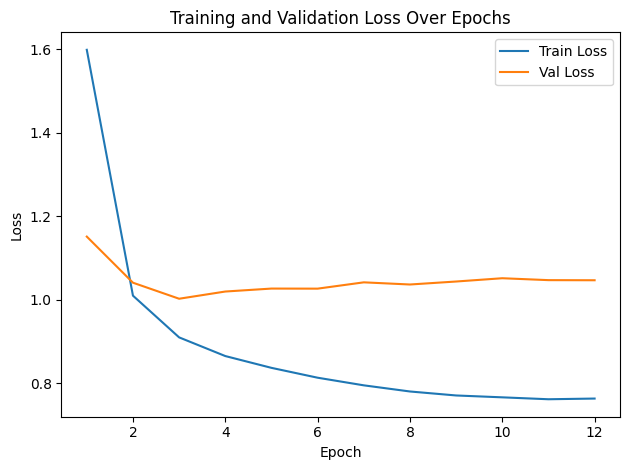

In [12]:
print("Train Losses:", train_losses)
print("Val (Dev) Losses:", val_losses)

# Plotting the training and val losses over a number of epochs
def plot_training_curves(train_values, val_values, metric_name='Loss'):
    epochs = np.arange(1, len(train_values) + 1)

    plt.figure()
    plt.plot(epochs, train_values, label=f'Train {metric_name}')
    plt.plot(epochs, val_values, label=f'Val {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Training and Validation {metric_name} Over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_training_curves(train_losses, val_losses, metric_name='Loss')

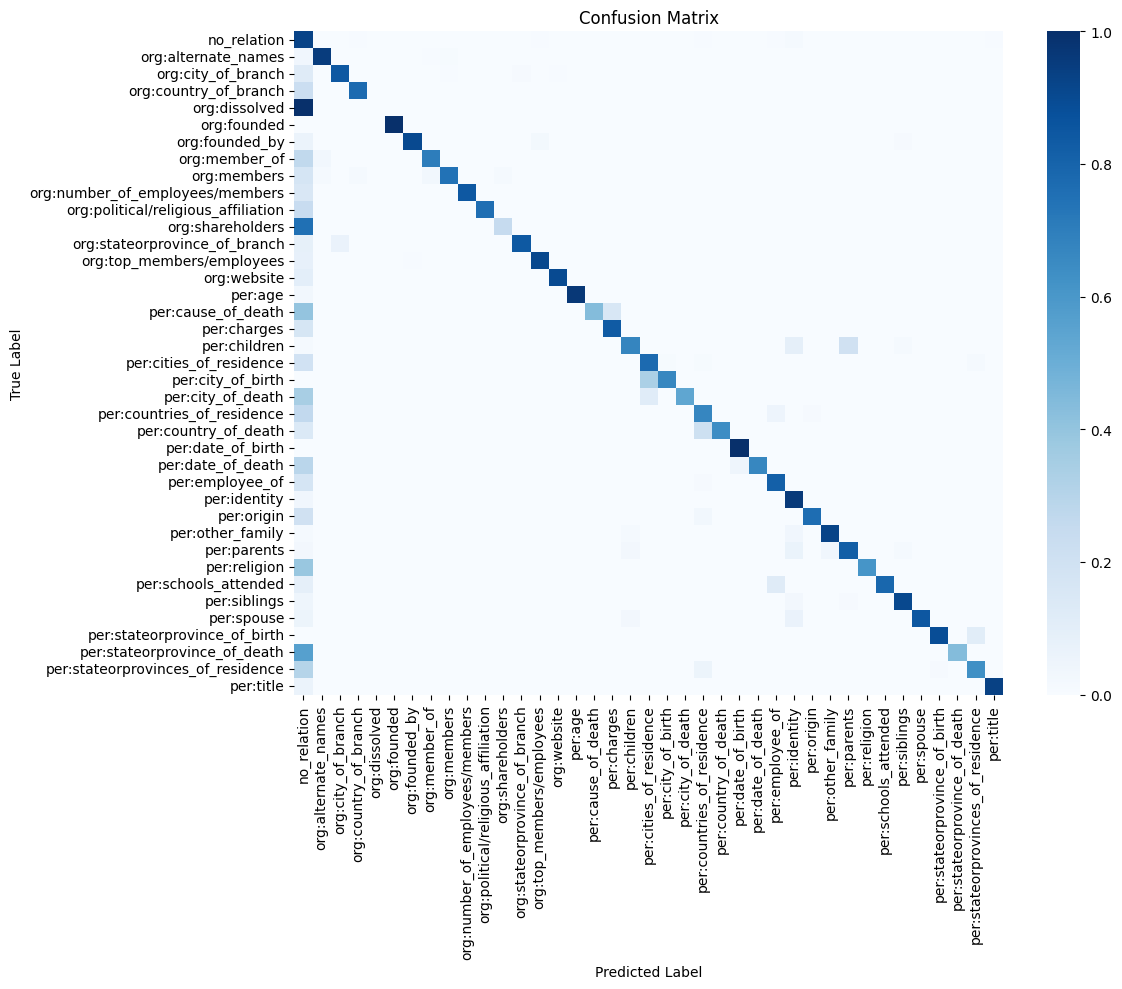

In [13]:
# Plotting a confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, figsize=(12, 10)):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_labels, test_preds, class_names, normalize=True)

In [14]:
# Helper function to save the model
def save_model(model, tokenizer, output_dir="bert_relation_extraction"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save model state
    with torch.cuda.device(device if torch.cuda.is_available() else 'cpu'):
        torch.save(
            {k: v.cpu() for k, v in model.state_dict().items()},
            os.path.join(output_dir, "model_state.pt")
        )
        torch.cuda.empty_cache()

    # Save tokenizer (including special tokens)
    tokenizer.save_pretrained(output_dir)

    # Save label mappings and other metadata
    metadata = {
        "label2id": label2id,
        "id2label": id2label,
        "model_type": "BERT with entity-aware attention",
        "max_length": MAX_LENGTH,
        "entity_markers": entity_markers,
        "dataset": "RE-TACRED",
        "num_labels": len(label2id)
    }

    # Add evaluation metrics
    if 'test_metrics' in globals():
        metadata['evaluation'] = {
            'micro_f1': test_micro_f1,
            'macro_f1': test_macro_f1,
            'filtered_f1': test_filtered_f1
        }

    with open(os.path.join(output_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Model, tokenizer, and metadata saved to {output_dir}")
    return True

# Helper function to load the saved model, tokenizer and label mappings
def load_model(output_dir="bert_relation_extraction"):
    with open(os.path.join(output_dir, "metadata.json"), 'r') as f:
        metadata = json.load(f)

    # Get label mappings
    label2id_loaded = metadata.get("label2id", {})
    id2label_loaded = metadata.get("id2label", {})

    # Convert string keys to integers
    if all(k.isdigit() for k in id2label_loaded.keys()):
        id2label_loaded = {int(k): v for k, v in id2label_loaded.items()}

    # Get params for the model
    max_length = metadata.get("max_length", 256)
    num_labels = metadata.get("num_labels", len(label2id_loaded))

    # Load tokenizer and initialize the model
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model = BERTForRelationExtraction(num_labels=num_labels)

    # Load state
    model_state = torch.load(
        os.path.join(output_dir, "model_state.pt"),
        map_location=torch.device('cpu')
    )
    model.load_state_dict(model_state)

    print(f"Model loaded from {output_dir} with {num_labels} classes")
    return model, tokenizer, label2id_loaded, id2label_loaded, max_length

# Save the final model
print("\nSaving model")
save_model(model, tokenizer, output_dir="bert_relation_extraction")

print("\nModel has been successfully saved.")





Saving model
Model, tokenizer, and metadata saved to bert_relation_extraction

Model has been successfully saved.


# Model Demo (Inference)

In [15]:
print("\nRELATION EXTRACTION DEMO")
print("_" * 50)
print("Usage: Enter a sentence with two entities, and specify their positions and types.")
print("The model will predict the relation between the entities.")
print("Example: 'John Smith is the CEO of Microsoft Corporation.'")
print("Subject: 'John Smith' (PERSON) at positions 0-1")
print("Object: 'Microsoft Corporation' (ORGANIZATION) at positions 6-7")

# Function requests user input for inference
def demo():
    print("\nRelation Extraction Demo")
    print("_" * 30)
    print("Enter 'q' to quit at any time")

    # Start loop for user and prompt user for the sentence, subject, object, and their indices
    while True:
        sentence = input("\nEnter a sentence (or 'q' to quit): ")
        if sentence.lower() in ['q', 'quit', 'exit']:
            break

        print("\nSubject entity:")
        subject_span = input("  Span (start,end): ")
        if subject_span.lower() in ['q', 'quit', 'exit']:
            break

        # Convert the input span to integers for the start and end
        subj_start, subj_end = map(int, subject_span.split(','))

        subject_type = input("  Type (PERSON, ORGANIZATION, etc.): ").upper()
        if subject_type.lower() in ['q', 'quit', 'exit']:
            break

        print("\nObject entity:")
        object_span = input("  Span (start,end): ")
        if object_span.lower() in ['q', 'quit', 'exit']:
            break

        obj_start, obj_end = map(int, object_span.split(','))

        object_type = input("  Type (PERSON, ORGANIZATION, etc.): ").upper()
        if object_type.lower() in ['q', 'quit', 'exit']:
            break

        # Make the relation prediction
        result = predict_relation(
            sentence,
            subj_start, subj_end, subject_type,
            obj_start, obj_end, object_type
        )

        # Displaying the results
        print("\nPrediction Results:")
        print(f"  Relation: {result['relation']}")
        print(f"  Confidence: {result['confidence']:.4f}")

        # Showing the top 3 relations based on probability
        print("\nTop 3 Relations:")
        for rel, prob in result['top_relations']:
            print(f"  - {rel}: {prob:.4f}")

# Uncomment the line below to run the demo
# demo()



RELATION EXTRACTION DEMO
__________________________________________________
Usage: Enter a sentence with two entities, and specify their positions and types.
The model will predict the relation between the entities.
Example: 'John Smith is the CEO of Microsoft Corporation.'
Subject: 'John Smith' (PERSON) at positions 0-1
Object: 'Microsoft Corporation' (ORGANIZATION) at positions 6-7


In [15]:
# If one wants to know all the subject and object types.
print("Subject Types:", sorted(all_subj_types))
print("Object Types:", sorted(all_obj_types))
print("All Entity Types:", sorted(all_entity_types))

Subject Types: ['ORGANIZATION', 'PERSON']
Object Types: ['CAUSE_OF_DEATH', 'CITY', 'COUNTRY', 'CRIMINAL_CHARGE', 'DATE', 'DURATION', 'IDEOLOGY', 'LOCATION', 'NATIONALITY', 'NUMBER', 'ORGANIZATION', 'PERSON', 'RELIGION', 'STATE_OR_PROVINCE', 'TITLE', 'URL']
All Entity Types: ['CAUSE_OF_DEATH', 'CITY', 'COUNTRY', 'CRIMINAL_CHARGE', 'DATE', 'DURATION', 'IDEOLOGY', 'LOCATION', 'NATIONALITY', 'NUMBER', 'ORGANIZATION', 'PERSON', 'RELIGION', 'STATE_OR_PROVINCE', 'TITLE', 'URL']


In [21]:
demo()


Relation Extraction Demo
Enter 'q' to quit at any time

Enter a sentence (or 'q' to quit): John Smith is married to Mary Smith

Subject entity:
  Span (start,end): 0,1
  Type (PERSON, ORGANIZATION, etc.): PERSON

Object entity:
  Span (start,end): 5,6
  Type (PERSON, ORGANIZATION, etc.): PERSON

Prediction Results:
  Relation: per:spouse
  Confidence: 0.9495

Top 3 Relations:
  - per:spouse: 0.9495
  - no_relation: 0.0069
  - per:identity: 0.0039


KeyboardInterrupt: Interrupted by user

In [16]:
# Pre-written non dyanmic examples

# The examples below include the expected relation and will show the predicted relation in the end
examples = [
    {
        "sentence": "John Smith is the CEO of Microsoft Corporation.",
        "subject_span": (0, 1),  # "John Smith"
        "subject_type": "PERSON",
        "object_span": (6, 7),   # "Microsoft Corporation."
        "object_type": "ORGANIZATION",
        "expected_relation": "org:top_members/employees"
    },
    {
        "sentence": "Elon Musk founded Tesla.",
        "subject_span": (0, 1),  # "Elon Musk"
        "subject_type": "PERSON",
        "object_span": (3, 3),   # "Tesla."
        "object_type": "ORGANIZATION",
        "expected_relation": "org:founded"
    },
    {
        "sentence": "Michael Jordan was born in Brooklyn.",
        "subject_span": (0, 1),  # "Michael Jordan"
        "subject_type": "PERSON",
        "object_span": (5, 5),   # "Brooklyn."
        "object_type": "CITY",
        "expected_relation": "per:city_of_birth"
    },
    {
        "sentence": "Barack Obama attended Harvard Law School.",
        "subject_span": (0, 1),  # "Barack Obama"
        "subject_type": "PERSON",
        "object_span": (3, 5),   # "Harvard Law School."
        "object_type": "ORGANIZATION",
        "expected_relation": "per:schools_attended"
    },
    {
        "sentence": "Tom is 30 years old.",
        "subject_span": (0, 0),  # "Tom"
        "subject_type": "PERSON",
        "object_span": (2, 2),   # "30"
        "object_type": "NUMBER",
        "expected_relation": "per:age"
    },
    {
        "sentence": "Emma Watson was born on April 15, 1990.",
        "subject_span": (0, 1),  # "Emma Watson"
        "subject_type": "PERSON",
        "object_span": (5, 7),   # "April 15, 1990"
        "object_type": "DATE",
        "expected_relation": "per:date_of_birth"
    },
    {
        "sentence": "George Clooney is married to Amal Clooney.",
        "subject_span": (0, 1),  # "George Clooney"
        "subject_type": "PERSON",
        "object_span": (5, 6),   # "Amal Clooney"
        "object_type": "PERSON",
        "expected_relation": "per:spouse"
    },
    {
        "sentence": "Apple's website is www.apple.com.",
        "subject_span": (0, 0),  # "Apple's"
        "subject_type": "ORGANIZATION",
        "object_span": (3, 3),   # "www.apple.com."
        "object_type": "URL",
        "expected_relation": "org:website"
    },
    {
        "sentence": "John Doe is a practicing Christian.",
        "subject_span": (0, 1),  # "John Doe"
        "subject_type": "PERSON",
        "object_span": (5, 5),   # "Christian."
        "object_type": "RELIGION",
        "expected_relation": "per:religion"
    },
    {
        "sentence": "Acme Corporation is a member of the Global Business Council.",
        "subject_span": (0, 1),  # "Acme Corporation"
        "subject_type": "ORGANIZATION",
        "object_span": (7, 9),   # "Global Business Council."
        "object_type": "ORGANIZATION",
        "expected_relation": "org:member_of"
    },
    {
        "sentence": "Jennifer Lawrence holds the title of Actress.",
        "subject_span": (0, 1),  # "Jennifer Lawrence"
        "subject_type": "PERSON",
        "object_span": (5, 5),   # "Actress."
        "object_type": "TITLE",
        "expected_relation": "per:title"
    },
    {
        "sentence": "Global Corp is based in Canada.",
        "subject_span": (0, 1),  # "Global Corp"
        "subject_type": "ORGANIZATION",
        "object_span": (3, 3),   # "Canada."
        "object_type": "COUNTRY",
        "expected_relation": "org:country_of_branch"
    },
    {
        "sentence": "She died of a heart attack.",
        "subject_span": (0, 0),  # "She"
        "subject_type": "PERSON",
        "object_span": (3, 4),   # "heart attack"
        "object_type": "CAUSE_OF_DEATH",
        "expected_relation": "per:cause_of_death"
    },
    {
        "sentence": "Acme Inc has 500 employees.",
        "subject_span": (0, 1),  # "Acme Inc"
        "subject_type": "ORGANIZATION",
        "object_span": (3, 3),   # "500"
        "object_type": "NUMBER",
        "expected_relation": "org:number_of_employees/members"
    },
    {
        "sentence": "The court charged John with theft.",
        "subject_span": (3, 3),  # "John"
        "subject_type": "PERSON",
        "object_span": (5, 5),   # "theft."
        "object_type": "CRIMINAL_CHARGE",
        "expected_relation": "per:charges"
    }
]

print("Running relation extraction examples:")

for i, ex in enumerate(examples, 1):
    result = predict_relation(
        ex["sentence"],
        ex["subject_span"][0], ex["subject_span"][1], ex["subject_type"],
        ex["object_span"][0], ex["object_span"][1], ex["object_type"]
    )
    print(f"\nExample {i}:")
    print("Sentence:", ex["sentence"])
    print(f"Subject: tokens {ex['subject_span']} ({ex['subject_type']})")
    print(f"Object: tokens {ex['object_span']} ({ex['object_type']})")
    print("Expected relation (for reference):", ex["expected_relation"])
    print("Predicted relation:", result.get("relation"))
    print("Confidence: {:.4f}".format(result.get("confidence", 0)))
    print("Top 3 Predictions:")
    for rel, conf in result.get("top_relations", []):
        print(f"  - {rel}: {conf:.4f}")


Running relation extraction examples:

Example 1:
Sentence: John Smith is the CEO of Microsoft Corporation.
Subject: tokens (0, 1) (PERSON)
Object: tokens (6, 7) (ORGANIZATION)
Expected relation (for reference): org:top_members/employees
Predicted relation: per:employee_of
Confidence: 0.9317
Top 3 Predictions:
  - per:employee_of: 0.9317
  - no_relation: 0.0089
  - per:identity: 0.0028

Example 2:
Sentence: Elon Musk founded Tesla.
Subject: tokens (0, 1) (PERSON)
Object: tokens (3, 3) (ORGANIZATION)
Expected relation (for reference): org:founded
Predicted relation: no_relation
Confidence: 0.9081
Top 3 Predictions:
  - no_relation: 0.9081
  - per:identity: 0.0042
  - per:title: 0.0033

Example 3:
Sentence: Michael Jordan was born in Brooklyn.
Subject: tokens (0, 1) (PERSON)
Object: tokens (5, 5) (CITY)
Expected relation (for reference): per:city_of_birth
Predicted relation: per:city_of_birth
Confidence: 0.9546
Top 3 Predictions:
  - per:city_of_birth: 0.9546
  - no_relation: 0.0053
  - 

# Saving the Models & files from Google Colab's session storage

In [17]:
from google.colab import files
import shutil

# Zip the entire folder
!zip -r bert_relation_extraction_12epoch.zip bert_relation_extraction

# Download the zipped folder
files.download('bert_relation_extraction_12epoch.zip')

  adding: bert_relation_extraction/ (stored 0%)
  adding: bert_relation_extraction/metadata.json (deflated 73%)
  adding: bert_relation_extraction/special_tokens_map.json (deflated 95%)
  adding: bert_relation_extraction/tokenizer_config.json (deflated 93%)
  adding: bert_relation_extraction/model_state.pt (deflated 7%)
  adding: bert_relation_extraction/added_tokens.json (deflated 78%)
  adding: bert_relation_extraction/vocab.txt (deflated 49%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Zip the entire folder
!zip -r bert_checkpoints12epoch.zip bert_checkpoints/

# Download the zipped folder
files.download('bert_checkpoints12epoch.zip')

updating: bert_checkpoints/ (stored 0%)
updating: bert_checkpoints/latest_checkpoint.pt


zip error: Interrupted (aborting)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>